<a href="https://colab.research.google.com/github/dasgupsa/Quora/blob/master/RNN_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## National Language Processing: Quora Question Pairs

### Introduction
Natural Language Processing (NLP) is a growing area and is slowly but steadily starting to make a meaningful impact on our society today. I have tried to study NLP by myself and implemented a small project to crystallise my knowledge. I have chosen a Kaggle competition - [Quora Question Pairs](https://www.kaggle.com/c/quora-question-pairs) to practice my knowledge on NLP.


### Problem Statement

Quora is a website, where the internet community ask questions to a large userbase. Questions seeking a particular answer can often be reworded in multiple ways but the answer is the same. If duplicate questions can be identified easily, this would save all parties a lot of duplicity and have the question answered quickly. 

A training dataset of 404,290 data points were provided by Kaggle. Each datapoint has two questions provided. A separate column is provided stating whether the two questions are a duplicate or not.
Currently, Quora uses a Random Forest model to identify duplicate questions. This is a problem apt for using NLP techniques, which will be used to try and solve the problem. A glossary of Key Terms is available at the end of the notebook.

### Roadmap

Every deep learning project has 4 main steps:

- **Data Collection**: obtaining the data.
- **Exploratory Data Analysis**: the dataset needs to be checked for missing values, null/inappropriate values and steps must be taken (if needed) to organise the dataset for inputting into the models. 
- **Model Building & Results**: building and tuning the models to maximise its performance.
- **Further Steps**: Assessing the results from the algorithms and deciding future steps. Are the results satisfactory and conclusive? Do we need to collect more data / tune exisiting models / search / develop other models to get a better result?

### Import Libraries

In [0]:
#General Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

#NLP Libraries
! pip install fuzzywuzzy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import re
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors # implements word vectors and their similarity look-ups.
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm_notebook
from tqdm import tqdm
from string import punctuation
import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('punkt')

#Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix  
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


# Deep Learning Libraries - using Keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Lambda
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU, RNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


### Data Collection: Load data from Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/mydata/QuoraFullTrain.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Exploratory Data Analysis

In data science, it is important to analyse the dataset before using the  Machine Learning models. [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html) is an excellent Python library which has several in-built features to help us with data analysis. Some of the key pandas functions are:

- head: a brief overview of the first few rows of the dataframe.
- shape:  provides the number of rows and columns in the dataframe.
- describe: get various summary statistics.
- info: the number and type of value in each column.

In [0]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [0]:
# We check if there are any null values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [0]:
# As there are null strings, we add the string 'empty' to empty strings
df = df.fillna('empty')
# Let's observe if there any any null values
print(df.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


Text(0.5, 1.0, 'Target Class')

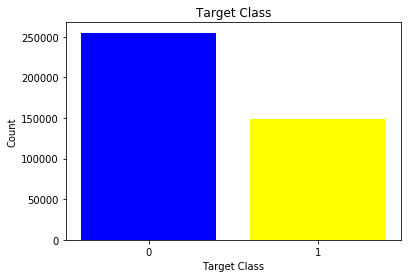

In [0]:
# We need to see the number in each target class [0 and 1 in this case]
plt.bar(df['is_duplicate'].unique(), df['is_duplicate'].value_counts(), color=['blue', 'yellow'])
plt.xticks([0,1])
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Target Class')

### Text Preprocessing 

 - Text data can be extremely unstructured and it must be pre-processed before it can be analysed.

In [0]:
def preprocess(x):
    x = str(x).lower()
    x = re.sub("′", "'",x)
    x = re.sub("’", "'",x)
    x = re.sub("cannot", "can not",x)
    x = re.sub("can't", "can not",x)
    x = re.sub("he's", "he is",x)
    x = re.sub("n't", " not",x)
    x = re.sub("what's", "what is",x)
    x = re.sub("won't", "will not",x)
    x = re.sub("it's", "it is",x)
    x = re.sub("'ve", " have",x)
    x = re.sub("i'm", "i am",x)
    x = re.sub("'ll", " will",x)
    x = re.sub("'re", " are",x)
    x = re.sub("she's", "she is",x)
    x = re.sub("'s", " own",x)
    x = re.sub("%", " percent ",x)
    x = re.sub("₹", " rupee ",x)
    x = re.sub("$", " dollar ",x)
    x = re.sub("€", " euro ",x)
    x = re.sub(",000,000", "m",x)
    x = re.sub(",000", "k",x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x
  


In [0]:
# Applying Text pre-processing on the questions
df['question1'] =  df['question1'].fillna("").apply(preprocess)
df['question2'] =  df['question2'].fillna("").apply(preprocess)

### Word Vector Models

- Word embedding is a very important part of NLP.  A word embedding provides a dense vector representation of words. An algorithm is used to train a set of fixed-length dense vectors based on a large body of text. Every word is represented by a point in the embedding space. 
- The position of the word is learnt and defined by its surrounding words. This allows the word embedding to learn something about the meaning of words. Hence,  the vector space representation of the words has words with similar meanings locally clustered within the space. Some good articles are [here](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/?source=post_page---------------------------) and [here](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).
- One can train their own word2vec word embedding model on their own data. This does require significant resources in terms of data and computing. Hence, pre-trained word embedding models are often used instead. 
- A pre-trained model is a file containing tokens (separate words) and their associated word vectors. Some examples are:

 - Word2Vec - Google has a pre-trained Word2Vec Model. It includes word vectors (300 dimensional) for a vocabulary of 3 million words and phrases trained on roughly 100 billion words from a Google News dataset. It can be downloaded [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

 - Glove - This was developed as an open source project at Stanford. This is an unsupervised algorithm to create vector representation of words. It can be downloaded [here](https://nlp.stanford.edu/projects/glove/).
 
- I will be using a pre-trained word embeddings model - the word2vec Google model. The word2vec pre-trained Google News corpus is used and loaded into a [Gensim](https://radimrehurek.com/gensim/)  Word2Vec model class. A tutorial on how to load word embeddings is available [here]( https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)





### Feature Creation

Strings cannot be input into machine learning models. Numerical features need to be created from the data to be input into the model.

### Simple Features

- Length of Question 1 
- Length of Question 2
- Difference in lengths of the two questions
- Number of words in Question 1
- Number of words in question2
- Number of common words between Question 1 and Question 2


### FuzzyWuzzy Features

FuzzyWuzzy is a Python library for calculating string features and string matching, which uses Levenshtein Distance to calculate the differences between sequences. An excellent tutorial is available [here](https://www.datacamp.com/community/tutorials/fuzzy-string-python).

- QRatio
- Partial ratio
- Partial token set ratio
- Partial token sort ratio
- Token set ratio
- Token sort ratio


### Word2Vec Features

- [Word mover distance](http://proceedings.mlr.press/v37/kusnerb15.pdf?source=post_page---------------------------): calculates the “distance” between two documents and uses word2vec vector embeddings of words.

- [Normalized word mover distance](https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html): same as "word mover distance" except that all word2vec vectors are normalized and have equal length.

- [Cosine distance](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cosine.html) - computes the Cosine distance between two 1-D arrays.

- [Cityblock distance](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cityblock.html) - computes the Manhattan distance between two 1-D arrays.

- [Euclidean distance](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.euclidean.html) -  computes the Euclidean distance between two 1-D arrays.

- [Minkowski distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.minkowski.html) -  computes the Minkowski distance between two 1-D arrays.

In [0]:
#Removing 3 columns in the dataset which are not needed
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

#Simple Features
df['q1_char_length'] = df.question1.apply(lambda x: len(str(x))) # no of characters
df['q2_char_length'] = df.question2.apply(lambda x: len(str(x))) # no of characters
df['diff_in_lengths'] = df['q1_char_length'] - df['q2_char_length']
df['q1_word_length'] = df.question1.apply(lambda x: len(str(x).split())) # no of words
df['q2_word_length'] = df.question2.apply(lambda x: len(str(x).split())) # no of words
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)


#Fuzzy Ratio features
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)


In [0]:
# Word2Vec Features

# Function calculates Word Movers Distance
# 2 questions, one from each column is input and using the model (which has the pre-trained Google
# Word2Vec loaded in) we calculate the word movers distance (unnormalised and normalised) between them.
def wmd(model, q1, q2):
  q1 = str(q1).lower().split()
  q2 = str(q2).lower().split()
  q1 = [w for w in q1 if w not in stop_words]
  q2 = [w for w in q2 if w not in stop_words]
  return model.wmdistance(q1,q2)

#Load Word2vec matrix in Gensim. This is the pre-trained embedding matrix
model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/mydata/GoogleNews-vectors-negative300.bin', binary=True)
# Calculating the Word Mover's Distance before normalising
df['wmd'] = df.apply(lambda x: wmd(model,x['question1'], x['question2']), axis=1)

# Calculating the Word Mover's Distance after normalising the vectors(all equal to 1)
# by making init_sims(replace=True)
model.init_sims(replace=True)
df['norm_wmd'] = df.apply(lambda x: wmd(model,x['question1'], x['question2']), axis=1)


# This function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())
  
#Creating question1_vectors and question_2 vectors on which different distance metrics will
# be used e.g. cosine, euclidean, cityblock(manhattan) and minkowski
question1_vectors = np.zeros((df.shape[0], 300))
for i, q in enumerate(df.question1.values):
    question1_vectors[i, :] = sent2vec(q)
    
question2_vectors  = np.zeros((df.shape[0], 300))
for i, q in enumerate(df.question2.values):
    question2_vectors[i, :] = sent2vec(q)

# Different vector distances calculated as features in the model
# These are the most common ones but there are more which could be experimented later on.
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
df.isnull().sum()

question1                        0
question2                        0
is_duplicate                     0
q1_char_length                   0
q2_char_length                   0
diff_in_lengths                  0
q1_word_length                   0
q2_word_length                   0
common_words                     0
fuzz_ratio                       0
fuzz_partial_ratio               0
fuzz_partial_token_set_ratio     0
fuzz_partial_token_sort_ratio    0
fuzz_token_set_ratio             0
fuzz_token_sort_ratio            0
wmd                              0
norm_wmd                         0
cosine_distance                  0
cityblock_distance               0
euclidean_distance               0
minkowski_distance               0
dtype: int64

In [0]:
df.drop(['question1', 'question2'], axis=1, inplace=True)
X = df.loc[:, df.columns != 'is_duplicate'] # All the features to be used for modelling
y = df.loc[:, df.columns == 'is_duplicate'] # The target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

In [0]:
#Standardising the dataset. We standardise on training set ONLY and apply it to test set.
# We DO NOT want test data information "leaking" into the dataset.

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model Building

- This will be broken in two sections
 - Random Forest which is the default technique used by Quora.
 - Deep Learning using Long Short Term Memory (LSTM) network.

#### [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- [An article](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/) which explains the inner workings of the algorithm.

- Hyperparameters: 
  -  N_estimators: number of trees you want to build.
  - Max_depth:  max number of levels in each decision tree.
  - Min_samples_split: min number of data points placed in a node before the node is split. 
  - Min_samples_leaf: min number of data points allowed in a leaf node.
  
  


In [0]:
rfc = RandomForestClassifier() # Instantiating the model
 
# Hyperparameters
param_grid = {"n_estimators": [10, 18, 22,30, 40, 50, 60, 70],
              "max_depth": [3, 5],
              "min_samples_split": [15, 20],
              "min_samples_leaf": [5, 10, 20]}

#GridSearch CV to find the best hyperparameters
# We do cross validation of 5 folds as we have a large dataset
cv = 5
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= cv)
CV_rfc.fit(X_train,y_train)

# This is a dictionary with the hyperparameters which produced the best result.
CV_rfc.best_params_

rfc = RandomForestClassifier(n_estimators= CV_rfc.best_params_['n_estimators'], 
                             max_depth= CV_rfc.best_params_['max_depth'], 
                             min_samples_leaf = CV_rfc.best_params_['min_samples_leaf'],
                             min_samples_split= CV_rfc.best_params_['min_samples_split'])


# fit the model with training set
rfc.fit(X_train, y_train)
y_log_loss_pred = rfc.predict_proba(X_test)
y_pred = rfc.predict(X_test)



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

In [0]:
# The classification metric used in the Kaggle competition was the log loss metric.
# Hence, log loss will be used to evaluate the algorithm's performance.
logLoss = log_loss(y_test, y_log_loss_pred)
accuracy = accuracy_score(y_test, y_pred)
print("LogLoss is {0:.3f}".format(logLoss))
print("Accuracy is {0:.3f}".format(accuracy))

LogLoss is 0.504
Accuracy is 0.713


#### Deep Learning Techniques

- A popular paper which has tried to answer sentence similarity is the paper [Siamese Recurrent Architectures for Learning Sentence Similarity](https://www.researchgate.net/publication/307558687_Siamese_Recurrent_Architectures_for_Learning_Sentence_Similarity). There is a picture of the Siamese Long Short Term Memory (LSTM) architecture below. 
- Here is an [excellent article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) to understand the LSTM architecture in more depth.

- Siamese LSTM models have two networks LSTM-left and LSTM-right which process the sentences in a given pair independently. Both LSTM-left and LSTM-right have same tied weights such that LSTM-left = LSTM-right. Such a model is useful for our task of duplicate query detection.



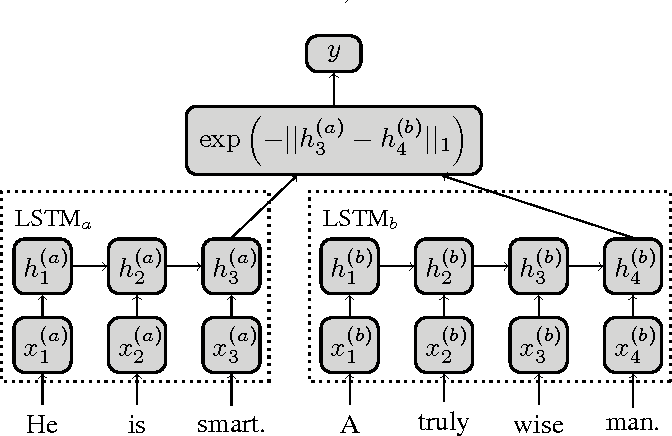

In [0]:
# Picture of Siamese LSTM Architecture from  
# the paper 'Siamese Recurrent Architectures for Learning Sentence Similarity'. 
# Distance metric used is the exponential of the negative Manhattan distance of the two vectors
from IPython.display import Image
Image("/content/gdrive/My Drive/mydata/LSTM.png")


In [0]:
# The csv file has to be reloaded. For the Random Forest Analysis, the questions were removed
# and converted to features. The questions are needed for Deep Learning analysis (RNN and LSTM) 
# hence, the data is reloaded again.

df_DL = pd.read_csv('/content/gdrive/My Drive/mydata/QuoraFullTrain.csv')
df_DL['question1'] = df_DL['question1'].apply(lambda x: (str(x)))
df_DL['question2'] = df_DL['question2'].apply(lambda x: (str(x)))
df = df.fillna('empty')

# Applying Text pre-processing on the questions
df['question1'] =  df['question1'].fillna("").apply(preprocess)
df['question2'] =  df['question2'].fillna("").apply(preprocess)

df_DL.drop(columns=['id','qid1','qid2'], inplace=True)
classes = df_DL['is_duplicate']
Q1 = list(df_DL['question1'])
Q2 = list(df_DL['question2'])

I will go through the procedure step by step. Initially:

- Text in its raw form cannot be used in deep learning models. The deep learning models only work with numerical tensors. 
- We break the sentence done into separate words (or characters) and convert each word into a numerical vector.
- The individual words are known as tokens and the process is tokenization.

- We need to convert the dataset (text data) into sequences of word indices. A "word index" is an integer ID for the word. 
- Only the top 20,000 most commonly occuring words in the dataset are considered. 
- Truncate the sequences (sentences) to a maximum length of 25 words.

In [0]:
max_sentence_len =25 # Cuts text off after these many words
max_features = 20000 # number of words to consider as features

tokenizer = Tokenizer(num_words=max_features) # Tokenizer which will take most common words
tokenizer.fit_on_texts(question1+question2) # # build the word index

# 'texts_to_sequences': Turns strings into lists of integer indices
Q1_word_sequences = tokenizer.texts_to_sequences(Q1) 
Q2_word_sequences = tokenizer.texts_to_sequences(Q2)

#unique words dictonary (alphabetical order): word is the key and the 1st postion it arrived
# is the key
word_index = tokenizer.word_index 

# truncate lengths to maxlen, using the pad_sequences function
q1_data = pad_sequences(Q1_word_sequences, maxlen=max_sentence_len)
q2_data = pad_sequences(Q2_word_sequences, maxlen=max_sentence_len)
y = np.array(classes, dtype=int) # all the targets converted to np array

# Make one table of q1_data and q2_data together - added together horizontally
X = np.stack((q1_data, q2_data), axis=1)

#split data up into training and testing sets
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.1, random_state=5)

# Splitting it up into 2 questions
# We split our data to ‘Q1_train’ and ‘Q2_train’ inputs (one for each side of the LSTM)
# We do the split for the validation data as well

Q1_train = X_Train[:,0]
Q2_train = X_Train[:,1]
Q1_val = X_Test[:,0]
Q2_val = X_Test[:,1]

- Word embedding is a methodology for representing words and documents using a dense vector representation. An [excellent article](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) describes in great detail why and how to use word embeddings in deep learning.
- Very briefly, in an embedding, words are represented by dense vectors where the vector is the projection of the word in continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding.

- We can either learn the word embedding or use pre-trained Word Vectors.

- A pre-trained model is a file containing tokens (separate words) and their associated word vectors. Some examples are:

 - Word2Vec - Google has a pre-trained Word2Vec Model. It includes word vectors (300 dimensional) for a vocabulary of 3 million words and phrases trained on roughly 100 billion words from a Google News dataset. It can be downloaded [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

 - Glove - This was developed as an open source project at Stanford. This is an unsupervised algorithm to create vector representation of words. It can be downloaded [here](https://nlp.stanford.edu/projects/glove/).
 
- I will be using a pre-trained word embeddings model, the Glove model 'glove.840B.300d.txt'.

- In summary, prepare an "embedding matrix" which will contain the embedding vector for each word in our word index. Load this embedding matrix into a Keras Embedding layer, set to be frozen (the weights - the embedding vectors, will not be updated during training). Please refer here for [the details](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/). This Embedding Layer is input into a LSTM Layer.

In [0]:
# Embedding Layers

#Folder containing Glove file
glove_dir = '/content/gdrive/My Drive/mydata/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.840B.300d.txt'))

# Build an index that maps words (as strings) to their vector representation
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
# Preparing the GloVe word-embeddings matrix to load into an Embedding layer. It
# is a matrix of shape (max_words, embedding_dim), where each entry i contains
# the word [i] and the embedding_dim-dimensional vector for the particular word

embedding_dim = 300 # dimension of Glove pre-trained word embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers.embeddings import Embedding
vector_dimension = 300
nb_words= embedding_matrix.shape[0]
# The Embedding layer is not trained, hence trainable = False
embedding_layer = Embedding(nb_words,vector_dimension,
        weights=[embedding_matrix],
        input_length=max_sentence_len,trainable=False)

W0812 09:34:48.238125 139640209569664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



- Please refer to image above. The LSTM network follows that image.

- Each question is fed into its own LSTM network. The output of the 2 LSTM networks (separate questions but same query) are fed into a distance metric.

- Then we classify whether the given pair of questions are duplicate or not.

In [0]:
# Functional Layer API format

# 2 different distance metrics will be tried out. This cell contains the common part of the 
# LSTM network

lstm_layer = LSTM(200) # 200 cells in LSTM layer

# One side of the LSTM
seq_1_input = Input(shape=(max_sentence_len,), dtype='int32')
embed_seq_1 = embedding_layer(seq_1_input)
left = lstm_layer(embed_seq_1)

# Another side of the LSTM
seq_2_input = Input(shape=(max_sentence_len,), dtype='int32')
embed_seq_2 = embedding_layer(seq_2_input)
right = lstm_layer(embed_seq_2)

W0812 09:35:16.346501 139640209569664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 09:35:16.361537 139640209569664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 09:35:16.374389 139640209569664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 09:35:16.375416 139640209569664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Two different distance metrics will be tried. They are:

- Exponent of the negative manhattan distance (as per image above) of the two vectors.
- Sum of the squared difference of the two vectors.

In [0]:
# This is a python function which will be used as a lambda function in Keras layer directly
# Below uses writing custom Keras layers, 2 useful guides are:
# https://keunwoochoi.wordpress.com/2016/11/18/for-beginners-writing-a-custom-keras-layer/
# https://keras.io/layers/writing-your-own-keras-layers/


# 2 different distance metrics

# sum of the squared difference between the two representation vectors
def sq_distance(vects):
    x, y = vects
    return K.sum(K.square(x - y), axis=1, keepdims=True)

# exponent of the negative manhattan distance of the two representation vectors
def expo_nega_manhat_distance(vects):
    x, y = vects
    return K.exp(-K.sum(K.abs(x-y), axis=1, keepdims=True))

# Output function
def vec_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# Function for plotting graphs. Input is dictionary of Neural Network training data 
# (accuracy and loss)
def plotGraphs(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


In [0]:
# LSTM model with Distance Metric: sum of the squared difference between the two representation vectors

distance=Lambda(sq_distance, output_shape=vec_output_shape)([left, right])
# We input distance into neural layer
denseLayer =Dense(20, activation='sigmoid')(distance)
# Regularisation techniques are applied - Dropout and Batch Normalisation
denseLayer = Dropout(0.5)(denseLayer)
batchNorm = BatchNormalization()(denseLayer)
# Final prediction of duplicate or not
prediction= Dense(1, activation='sigmoid')(batchNorm) # final output of whether it is duplicate or not

# Final output for model in functional API format
model = Model(input=[seq_1_input, seq_2_input], output=prediction)
epochs = 20

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
hist_sq=model.fit([Q1_train, Q2_train], y_Train, validation_data=([Q1_val, Q2_val], y_Test), verbose=1, 
          epochs= epochs, batch_size=500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Train on 363861 samples, validate on 40429 samples
Epoch 1/20
363861/363861 [==============================] - 106s 291us/step - loss: 0.5730 - acc: 0.7259 - val_loss: 0.5466 - val_acc: 0.7401
Epoch 2/20
363861/363861 [==============================] - 102s 281us/step - loss: 0.4965 - acc: 0.7911 - val_loss: 0.5397 - val_acc: 0.7473
Epoch 3/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.4617 - acc: 0.8126 - val_loss: 0.5414 - val_acc: 0.7509
Epoch 4/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.4359 - acc: 0.8276 - val_loss: 0.5486 - val_acc: 0.7530
Epoch 5/20
363861/363861 [==============================] - 102s 281us/step - loss: 0.4159 - acc: 0.8378 - val_loss: 0.5534 - val_acc: 0.7564
Epoch 6/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.3996 - acc: 0.8461 - val_loss: 0.5644 - val_acc: 0.7572
Epoch 7/20
363861/363861 [==============================] - 102s 279us/step - loss: 0.3882 - acc:

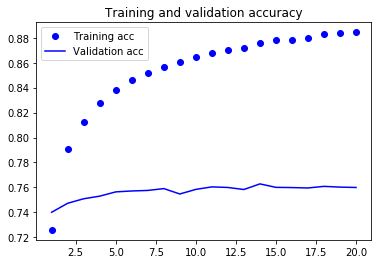

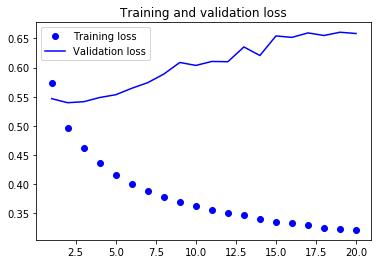

In [0]:
plotGraphs(hist_sq)

In [0]:
# LSTM model with Distance Metric: exponent of the negative manhattan distance of the two representation vectors

distance=Lambda(expo_nega_manhat_distance, output_shape=vec_output_shape)([left, right])
# We input distance into neural layer
denseLayer =Dense(20, activation='sigmoid')(distance)

# Regularisation techniques are applied - Dropout and Batch Normalisation
denseLayer = Dropout(0.4)(denseLayer)
batchNorm = BatchNormalization()(denseLayer)

# Final prediction of duplicate or not
prediction=Dense(1, activation='sigmoid')(batchNorm)

# Final output for model in functional API format
model = Model(input=[seq_1_input, seq_2_input], output=prediction)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
hist_exp=model.fit([Q1_train, Q2_train], y_Train, validation_data=([Q1_val, Q2_val], y_Test), verbose=1,
                   shuffle = True, epochs= epochs, batch_size=500)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


Train on 363861 samples, validate on 40429 samples
Epoch 1/20
363861/363861 [==============================] - 106s 292us/step - loss: 0.6409 - acc: 0.6464 - val_loss: 0.5504 - val_acc: 0.7591
Epoch 2/20
363861/363861 [==============================] - 102s 279us/step - loss: 0.4399 - acc: 0.8235 - val_loss: 0.5412 - val_acc: 0.7599
Epoch 3/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.3798 - acc: 0.8575 - val_loss: 0.5646 - val_acc: 0.7637
Epoch 4/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.3542 - acc: 0.8699 - val_loss: 0.5994 - val_acc: 0.7599
Epoch 5/20
363861/363861 [==============================] - 102s 279us/step - loss: 0.3378 - acc: 0.8775 - val_loss: 0.6074 - val_acc: 0.7635
Epoch 6/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.3269 - acc: 0.8829 - val_loss: 0.6219 - val_acc: 0.7634
Epoch 7/20
363861/363861 [==============================] - 102s 280us/step - loss: 0.3207 - acc:

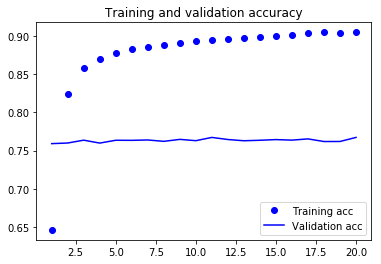

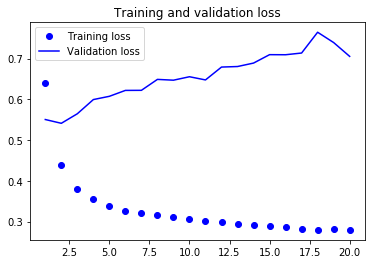

In [0]:
plotGraphs(hist_exp)

### Comparison

The table below shows the performance of all the different classifiers.

In [0]:
# Table created manually.
import pandas as pd
ResultsData = []
li = []
li.append('Random Forest')
li.append(0.713)
ResultsData.append(li)

li = []
li.append('LSTM - Squared distance')
li.append(0.76)
ResultsData.append(li)

li = []
li.append('LSTM - Exponential of Negative Manhattan Distance')
li.append(0.77)
ResultsData.append(li)

df_data = pd.DataFrame(ResultsData)
df_data.columns = ["Algorithm", "Accuracy"]
df_data

,Algorithm,Accuracy
0,Random Forest,0.713
1,LSTM - Squared distance,0.760
2,LSTM - Exponential of Negative Manhattan Distance,0.770


### Conclusion

 - From the 3 algorithms used, LSTM with Exponential of Negative Manhattan Distance has the best accuracy.
 - Its accuracy was marginally better than the sum of Squared distance approach, which has an accuracy of 76%. 
 - Both the Deep Learning approaches were better than the Quora suggested method of using Random Forests.

### Further Work

This article was written primarily as a learning tool to learn more about NLP.  Further work that could be done includes:

- More extensive text processing to see the impact on model accuracy with varying degree of text processing.
-Complex feature creation: some NLP features were created in which [this paper](https://www.researchgate.net/publication/259181798_A_Survey_of_Text_Similarity_Approaches) was a huge help. Feature creation is only limited to the imagination and computing power and more complex features should be investigated to improve the model's performance.  
- Hyperparameter Tuning: try in depth hyperparameter tuning, including different network sizes,  optimisers and loss functions. In addition, [ensemble stacking](https://machinelearningmastery.com/stacked-long-short-term-memory-networks/) should also be looked into as they are often used for boosting model performance.
- Word Embeddings: Instead of using pre-trained word embeddings, create our own word embeddings based on the dataset, which may improve model performance.
- Data Augmentation:  the more data, we have to train our models, the more we can tune its performance and decrease generalisation error.
Data augmentation techniques are well-known techniques to increase sample size and should be looked into.

### References

This is a list of good websites, which I have found very useful:

- [Intuitive Understanding of Word vectors](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/?utm_source=ELMoNLParticle&utm_medium=blog)
- [Tfifd Tutorial](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)
- [Beginner's guide to Regex](https://www.analyticsvidhya.com/blog/2015/06/regular-expression-python/)
- [Word2Vec Tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
- [How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)
- [Using Word Embedding Vectors in Deep Learning](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

### Key Terms

There are some terms, which are very common in Machine Learning literature and a brief explanation is provided:

- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning): There are input variables (x) and an output variable (y). We need to find an algorithm to learn the mapping function from the input to the output.
- [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning): There is only input data (x) and no corresponding output variable (y). The aim is to model the underlying structure or distribution in the data in order to learn more about the data.
- [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html): It's a technique where the data is split into several parts. We tune our model on some parts of the data. We test the model's performance on the data which was kept aside. For a detailed explanation, please refer to this [link](https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html)
- [Log Loss (logistic loss/cross-entropy loss)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) - A performance metric used to evaluate the probability outputs of a classifier as opposed to its predictions.
- [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) - A performance measure which determines the percentage of samples the algorithm was able to classify correctly.
- [Perfomance Measures (precision, recall, f1-score) ](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) - Some other measures which help us determine the quality of the algorithm's perfomance.
- [ROC Curves for Binary Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) - Receiver Operating Characteristic (ROC) curves are an important classification metric, especially for binary classification. For deep learning models, please check this [link](https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/).
